In [1]:
from bokeh.plotting import figure, output_file, output_notebook, show
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def rotate(x,y,θ,origin):
    θ = math.radians(θ)
    x_ = x * math.cos(θ) - y * math.sin(θ)
    y_ = x * math.sin(θ) + y * math.cos(θ)
    x_ += origin[0]; y_ += origin[1]
    return x_,y_

def line(p1, p2):
    a = (p1[1] - p2[1])
    b = (p2[0] - p1[0])
    c = (p1[0]*p2[1] - p2[0]*p1[1])
    return a, b, -c

def line_intersection(l1, l2):
    D  = l1[0] * l2[1] - l1[1] * l2[0]
    Dx = l1[2] * l2[1] - l1[1] * l2[2]
    Dy = l1[0] * l2[2] - l1[2] * l2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

def error_calc(pt1,pt2,origin):
    def arc(pt,origin):
        o = np.linalg.norm(np.array([pt1[0],origin[1]])-np.array([pt1[0],pt1[1]]))
        h = np.linalg.norm(np.array([origin[0],origin[1]])-np.array([pt1[0],pt1[1]]))
        max_θ = np.arcsin(o/h)*0.5
        return math.degrees(max_θ)
    max1_θ = arc(pt1,origin)
    max2_θ = arc(pt2,origin)
    return max1_θ,max2_θ

In [3]:
ou = 5
mirror_size = 2
laser_origin = [ou,-20]
seglen = 1000
las_w = 3

dist = 25
m1_center = [ou,ou]
m2_center = [dist+m1_center[0],ou]
m1_θ = 45#3.78*0.5
m2_θ = -45

pinhole = True
pinhole_size = 0.1
pinhole_dist = 10
pinhole_center = [ou+pinhole_dist,ou]
pinhole_edge=(mirror_size/2)-pinhole_size

plt.rcParams['figure.figsize'] = [15, 2]

#p = figure(x_range=[0,dist+mirror_size+5+m1_center[0]], y_range=(0, mirror_size+m1_center[1]))

In [4]:
## mirror distance, mirror size, θ mirror 1, θ mirror 2, pinhole toggle, pinhole distance, pinhole size
def refresh(dist,mirror_size,m1_θ,m2_θ,pinhole,pinhole_dist,pinhole_size):
    pinhole_pass = False; mirror2_pass=False
    m2_center = [dist+m1_center[0],ou]
    m1_x1,m1_y1=rotate(-mirror_size/2,0,m1_θ,m1_center)
    m1_x2,m1_y2=rotate(mirror_size/2,0,m1_θ,m1_center)

    m2_x1,m2_y1=rotate(-mirror_size/2,0,m2_θ,m2_center)
    m2_x2,m2_y2=rotate(mirror_size/2,0,m2_θ,m2_center)

    refl_θ_1 = math.radians(90-((90-m1_θ)*2))
    refl_path_1 = [math.cos(refl_θ_1)*seglen + m1_center[0],math.sin(refl_θ_1)*seglen + m1_center[1]]

    line1 = line([m1_center[0],m1_center[1]],[refl_path_1[0],refl_path_1[1]])
    line2 = line([m2_x1,m2_y1],[m2_x2,m2_y2])
    intercept_x,intercept_y = line_intersection(line1,line2)


    refl_θ_2 = 2*math.radians(m2_θ) - refl_θ_1
    refl_path_2 = [math.cos(refl_θ_2)*seglen + intercept_x,math.sin(refl_θ_2)*seglen + intercept_y]
    ax = sns.scatterplot(x=[laser_origin[0]],y=[laser_origin[1]],color="red",s=50)

    if pinhole == True:
        pinline = line([ou+pinhole_dist,ou-(pinhole_size/2)],[ou+pinhole_dist,ou+(pinhole_size/2)])
        pintercept_x,pintercept_y = line_intersection(line1,pinline)
        if pintercept_y <= ou+(pinhole_size/2) and pintercept_y >= ou-(pinhole_size/2):
            pinhole_pass = True
        pt1 = [ou+pinhole_dist,ou-(pinhole_size/2)]
        pt2 = [ou+pinhole_dist,ou+(pinhole_size/2)]
        ax.vlines(pt1[0],pt1[1],pt1[1]-pinhole_edge,color="blue",lw=3)
        ax.vlines(pt2[0],pt2[1],pt2[1]+pinhole_edge,color="blue",lw=3)
        ax.vlines(pt1[0],pt2[1],pt1[1],color="pink",lw=3)
        sns.lineplot(x=[m1_center[0],ou+pinhole_dist],y=[m1_center[1],ou-(pinhole_size/2)],color="pink")
        sns.lineplot(x=[m1_center[0],ou+pinhole_dist],y=[m1_center[1],ou-(pinhole_size/2)],color="pink")
        err=(error_calc(pt1,pt2,m1_center))
        print("Error tolerance for pinhole size {:.2f}cm at distance {:d}cm is {:.2f}°".format(pinhole_size,pinhole_dist,err[0]))
       

    sns.lineplot(x=[m1_x1,m1_x2],y=[m1_y1,m1_y2],linewidth=2,color="black")
    sns.scatterplot(x=[m1_center[0]],y=[m1_center[1]],color="black")

    sns.lineplot(x=[m2_x1,m2_x2],y=[m2_y1,m2_y2],linewidth=2,color="black")
    sns.scatterplot(x=[m2_center[0]],y=[m2_center[1]],color="black")

    ### Put in our error tracks here
    sns.lineplot(x=[m1_center[0],m2_x2],y=[m1_center[1],m2_y2],linewidth=1,color="green")
    sns.lineplot(x=[m1_center[0],m2_x1],y=[m1_center[1],m2_y1],linewidth=1,color="green")

    pt1 = [m2_x2,m2_y2]
    pt2 = [m2_x1,m2_y1]
    err = error_calc(pt1,pt2,m1_center)
    print("Error tolerance to hit mirror 2 at size {:d}cm and distance {:d}cm is {:.2f}°".format(int(mirror_size),dist,err[0]))

    if intercept_y >= m2_y2 and intercept_y <= m2_y1:
        sns.lineplot(x=[m1_center[0],intercept_x],y=[m1_center[1],intercept_y],linewidth=las_w,color="red")
        sns.lineplot(x=[intercept_x,refl_path_2[0]],y=[intercept_y,refl_path_2[1]],linewidth=las_w,color="red")
    else:
        mirror2_pass = False
        #print("pinhole pass successful")
        sns.lineplot(x=[m1_center[0],refl_path_1[0]],y=[m1_center[1],refl_path_1[1]],linewidth=1,color="red")

    ax.vlines(x=laser_origin[0],ymin = laser_origin[1],ymax = m1_center[1],lw=las_w,color="red")
    ax.set(xlim=(0,(dist+mirror_size+5+m1_center[0])))
    ax.set(ylim=(3,mirror_size+m1_center[1]))
    print("Mirror 1 θ: {:.2f}, Mirror 2 θ: {:.2f}".format(m1_θ,m2_θ))
    plt.show()

Error tolerance for pinhole size 0.50cm at distance 5cm is 1.43°
Error tolerance to hit mirror 2 at size 2cm and distance 10cm is 1.89°
Mirror 1 θ: 45.00, Mirror 2 θ: -45.00


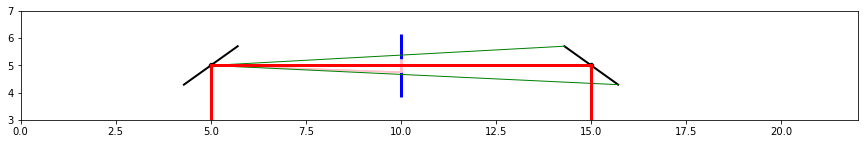

Error tolerance for pinhole size 0.10cm at distance 5cm is 0.29°
Error tolerance to hit mirror 2 at size 2cm and distance 100cm is 0.20°
Mirror 1 θ: 45.00, Mirror 2 θ: -45.00


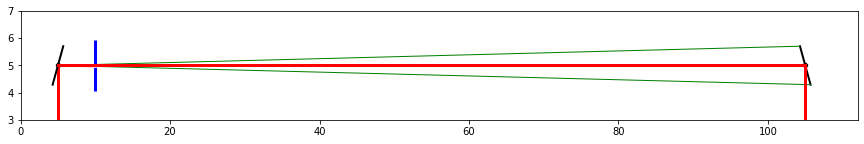

Error tolerance for pinhole size 0.10cm at distance 5cm is 0.29°
Error tolerance to hit mirror 2 at size 2cm and distance 25cm is 0.79°
Mirror 1 θ: 50.00, Mirror 2 θ: -45.00


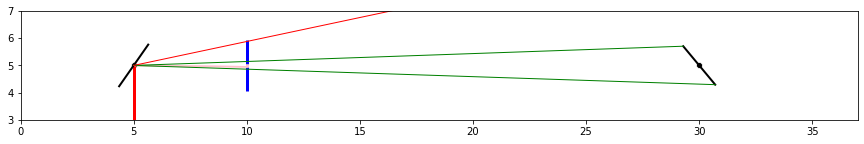

In [5]:
## mirror distance, mirror size, θ mirror 1, θ mirror 2, pinhole toggle, pinhole distance, pinhole size
refresh(10,2,45,-45,True,5,0.5)
refresh(100,2,45,-45,True,5,0.1)
refresh(25,2,50,-45,True,5,0.1)